# Project: Explainable COVID-19 Infection Segmentation using LIME and ConvNeXt

# Overview: 
This project demonstrates the use of Explainable Artificial Intelligence (XAI) techniques — specifically LIME (Local Interpretable Model-agnostic Explanations) — to generate interpretable infection localization masks for COVID-19 chest X-ray images.
The base model used for predictions is ConvNeXt, a modern convolutional architecture that achieves high accuracy while maintaining interpretability through localized feature analysis.
The main goal is to visualize which regions of the lungs influenced the model’s COVID-positive predictions, and to generate infection masks that can be compared with ground-truth segmentation or used for further evaluation.

# Source: 
COVID-QU-Ex dataset (segmented chest X-rays with lung masks).

# Workflow Summary
1. Setup and Configuration
Define paths for:
Input X-ray images (/kaggle/input/covid-qu-ex-masked/test/COVID-19)
Predicted infection masks (existing dataset in /kaggle/input/predicted-infection-masks)
Working output directory (/kaggle/working/predicted_infection_masks/convnext/test/COVID-19)
Initialize the LIME Image Explainer for pixel-level explanations.
2. Smart Reuse of Existing Predictions
Before running LIME (which is computationally heavy), the script:
Checks if an infection mask for an image already exists in:
/kaggle/working/ → skips (already generated)
/kaggle/input/predicted-infection-masks/ → copies to /kaggle/working/
Only runs LIME for the remaining images that have no existing mask.
This design allows efficient incremental execution — perfect for long Kaggle sessions or when resuming runs.
3. Generating Infection Masks using LIME
For each image needing prediction:
The image is passed through the pretrained ConvNeXt classifier via the predict_fn function.
LIME perturbs the image multiple times (num_samples=1000) to analyze how local pixel changes affect the model’s confidence.
The resulting LIME heatmap is converted into an interpretable infection mask by:
Keeping only positive relevance pixels (areas that increase “COVID” prediction confidence).
Normalizing the heatmap to a [0–1] scale.
Thresholding at 0.5 to create a binary mask.
The binary infection mask is then restricted to the lung region (using the provided lung segmentation mask) to eliminate irrelevant areas.
The final binary mask is saved in the /kaggle/working/ directory.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# installing the library to perform XAI using LIME

!pip install lime

In [3]:
#having the major imports

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

Multiple models are present within the models folder. You can apply any model by keeping the rest of the code same and just chnaging the next cell's code according to the model. 
Currently, it is using the "ConvNeXt" model present in the folder.

In [4]:
#Loading the trained model by one of my team members on which LIME is applied
import torch
import torch.nn as nn
from torchvision import models
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('convnext_base', pretrained=False, num_classes=3)
model.load_state_dict(torch.load("/kaggle/input/models/models/convnext_base_best.pth", map_location=device))
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

# Prediction for a single image

In [5]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load an image
img_path = "/kaggle/input/covid-qu-ex-masked/covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: COVID-19
Probabilities: [0.9999945163726807, 5.532601335289655e-06, 3.033969464549813e-10]


In [6]:
# a prediction function which take an image as an input and return its probabilities for predicted classes
def predict_fn(images):
    model.eval()
    images = [transform(Image.fromarray(img)).unsqueeze(0).to(device) for img in images]
    images = torch.cat(images).to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

In [7]:
# Load one test image
img_path = "/kaggle/input/covid-qu-ex-masked/covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain prediction
explanation = explainer.explain_instance(
    image_np,          # raw image in numpy
    predict_fn,        # function returning class probabilities
    top_labels=1,      # number of top classes to explain
    hide_color=0,      # background color for masked regions
    num_samples=1000   # number of perturbed samples
)

  0%|          | 0/1000 [00:00<?, ?it/s]

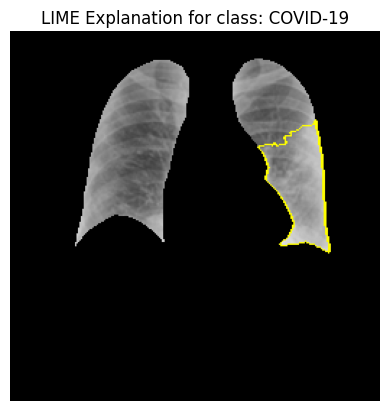

In [8]:
# Pick the class index that was predicted
predicted_label = np.argmax(predict_fn([image_np])[0])

# Get explanation for this label
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=True,
    hide_rest=False,
    num_features=1,       # number of superpixels to highlight
    min_weight=0.01
)

# Plot result
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for class: {classes[predicted_label]}")
plt.axis('off')
plt.show()

# Generating infection masks for all the images

In [9]:
def predict_fn(images):
    model.eval()
    images = [transform(Image.fromarray(img)).unsqueeze(0).to(device) for img in images]
    images = torch.cat(images).to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

In [10]:
import os
import cv2
import numpy as np
from PIL import Image
from lime import lime_image
from tqdm import tqdm
import shutil

# === CONFIGURATION ===
test_folder = "/kaggle/input/covid-qu-ex-masked/covid_qu_ex_masked/test/COVID-19"
input_mask_root = "/kaggle/input/predicted-infection-masks/predicted_infection_masks/convnext/test/COVID-19"
working_mask_root = "/kaggle/working/predicted_infection_masks/convnext/test/COVID-19"

# Create working output directory if not exists
os.makedirs(working_mask_root, exist_ok=True)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Get all test image filenames (PNG/JPG)
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith((".png", ".jpg"))]

print(f"Found {len(image_files)} total test images.")

# === MAIN LOOP ===
for filename in tqdm(image_files, desc="Processing infection masks", unit="image"):
    img_path = os.path.join(test_folder, filename)
    working_save_path = os.path.join(working_mask_root, filename)
    input_mask_path = os.path.join(input_mask_root, filename)

    # ✅ 1. If mask already exists in /kaggle/working/, skip
    if os.path.exists(working_save_path):
        continue

    # ✅ 2. If mask exists in /kaggle/input/, copy it
    elif os.path.exists(input_mask_path):
        shutil.copy(input_mask_path, working_save_path)
        continue

    # ✅ 3. Else, generate a new mask using LIME
    image = Image.open(img_path).convert("RGB")
    image_np = np.array(image)

    # Load corresponding lung mask (assuming same filename)
    lung_mask_path = os.path.join(test_folder, filename)
    lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)

    if lung_mask is None:
        print(f"⚠️ Skipping {filename}: lung mask not found.")
        continue

    # Binary mask: 1 for lung, 0 for background
    lung_binary = (lung_mask > 10).astype(np.uint8)

    # Get LIME explanation
    try:
        explanation = explainer.explain_instance(
            image_np,
            predict_fn,           # Must be defined earlier
            top_labels=1,
            hide_color=0,
            num_samples=1000
        )
    except Exception as e:
        print(f"❌ LIME failed on {filename}: {e}")
        continue

    # Get predicted class
    predicted_label = explanation.top_labels[0]

    # Build heatmap
    dict_heatmap = dict(explanation.local_exp[predicted_label])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    heatmap = np.maximum(heatmap, 0)

    # Normalize safely
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Threshold to create infection mask
    threshold = 0.5
    bw_mask = (heatmap_norm > threshold).astype(np.uint8)

    # Apply lung mask restriction
    bw_mask = bw_mask * lung_binary

    # Convert to 0–255, ensure white = infection
    bw_mask = (bw_mask * 255).astype(np.uint8)
    if np.mean(bw_mask) > 128:
        bw_mask = 255 - bw_mask

    # ✅ Save mask to working directory
    cv2.imwrite(working_save_path, bw_mask)

print("✅ All infection masks are now available in /kaggle/working/predicted_infection_masks/convnext/test/COVID-19.")


Found 583 total test images.


Processing infection masks:   0%|          | 0/583 [00:00<?, ?image/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   0%|          | 2/583 [00:16<1:18:07,  8.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   1%|          | 3/583 [00:32<1:52:33, 11.64s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   1%|          | 4/583 [00:49<2:11:45, 13.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   1%|          | 5/583 [01:07<2:24:19, 14.98s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   1%|          | 6/583 [01:25<2:34:17, 16.04s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   1%|          | 7/583 [01:44<2:42:49, 16.96s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   2%|▏         | 9/583 [02:03<2:09:28, 13.53s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   2%|▏         | 10/583 [02:23<2:22:52, 14.96s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   2%|▏         | 11/583 [02:41<2:31:24, 15.88s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   2%|▏         | 13/583 [02:59<2:03:11, 12.97s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   2%|▏         | 14/583 [03:18<2:15:59, 14.34s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   3%|▎         | 15/583 [03:37<2:26:41, 15.50s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   3%|▎         | 16/583 [03:56<2:34:32, 16.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   3%|▎         | 17/583 [04:14<2:40:01, 16.96s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   3%|▎         | 18/583 [04:33<2:43:36, 17.37s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   3%|▎         | 19/583 [04:52<2:47:06, 17.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   4%|▍         | 22/583 [05:10<1:46:57, 11.44s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   4%|▍         | 23/583 [05:29<2:00:55, 12.96s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   4%|▍         | 24/583 [05:48<2:12:24, 14.21s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   4%|▍         | 25/583 [06:07<2:23:14, 15.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   4%|▍         | 26/583 [06:26<2:31:34, 16.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   5%|▍         | 28/583 [06:44<2:03:35, 13.36s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   5%|▌         | 30/583 [07:03<1:48:55, 11.82s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   5%|▌         | 31/583 [07:22<2:02:12, 13.28s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   5%|▌         | 32/583 [07:40<2:13:35, 14.55s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   6%|▌         | 33/583 [07:59<2:23:35, 15.66s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   6%|▌         | 34/583 [08:18<2:30:25, 16.44s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   6%|▌         | 35/583 [08:37<2:36:00, 17.08s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   6%|▌         | 36/583 [08:55<2:39:23, 17.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   6%|▋         | 37/583 [09:14<2:43:00, 17.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   7%|▋         | 38/583 [09:33<2:44:51, 18.15s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   7%|▋         | 39/583 [09:52<2:45:54, 18.30s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   7%|▋         | 42/583 [10:10<1:44:25, 11.58s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   7%|▋         | 43/583 [10:29<1:57:49, 13.09s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   8%|▊         | 44/583 [10:48<2:09:52, 14.46s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   8%|▊         | 45/583 [11:07<2:19:31, 15.56s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   8%|▊         | 46/583 [11:26<2:26:45, 16.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   8%|▊         | 48/583 [11:45<1:59:31, 13.41s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   9%|▊         | 50/583 [12:03<1:45:50, 11.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   9%|▊         | 51/583 [12:22<1:58:26, 13.36s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   9%|▉         | 52/583 [12:41<2:09:28, 14.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:   9%|▉         | 54/583 [13:00<1:51:03, 12.60s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  10%|▉         | 56/583 [13:19<1:40:19, 11.42s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  10%|▉         | 58/583 [13:38<1:34:03, 10.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  10%|█         | 59/583 [13:57<1:47:41, 12.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  10%|█         | 60/583 [14:15<2:00:02, 13.77s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  10%|█         | 61/583 [14:34<2:10:33, 15.01s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  11%|█         | 63/583 [14:53<1:50:14, 12.72s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  11%|█         | 64/583 [15:12<2:01:43, 14.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  11%|█         | 65/583 [15:31<2:11:22, 15.22s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  11%|█▏        | 66/583 [15:50<2:19:30, 16.19s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  12%|█▏        | 68/583 [16:08<1:54:00, 13.28s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  12%|█▏        | 70/583 [16:27<1:41:24, 11.86s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  12%|█▏        | 71/583 [16:46<1:53:50, 13.34s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  12%|█▏        | 72/583 [17:05<2:03:48, 14.54s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  13%|█▎        | 73/583 [17:24<2:12:51, 15.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  13%|█▎        | 74/583 [17:42<2:19:42, 16.47s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  13%|█▎        | 75/583 [18:01<2:25:08, 17.14s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  13%|█▎        | 76/583 [18:20<2:28:34, 17.58s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  13%|█▎        | 77/583 [18:39<2:31:14, 17.93s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  13%|█▎        | 78/583 [18:58<2:33:12, 18.20s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  14%|█▎        | 79/583 [19:17<2:34:25, 18.38s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  14%|█▎        | 80/583 [19:36<2:35:33, 18.55s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  14%|█▍        | 82/583 [19:54<2:00:01, 14.38s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  14%|█▍        | 83/583 [20:13<2:09:00, 15.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  14%|█▍        | 84/583 [20:32<2:15:56, 16.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  15%|█▍        | 85/583 [20:51<2:21:42, 17.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  15%|█▍        | 87/583 [21:10<1:53:39, 13.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  15%|█▌        | 88/583 [21:29<2:03:10, 14.93s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  15%|█▌        | 89/583 [21:47<2:11:01, 15.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  15%|█▌        | 90/583 [22:06<2:16:46, 16.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  16%|█▌        | 91/583 [22:25<2:21:21, 17.24s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  16%|█▌        | 92/583 [22:44<2:24:18, 17.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  16%|█▌        | 93/583 [23:03<2:27:02, 18.00s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  16%|█▌        | 94/583 [23:21<2:28:44, 18.25s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  16%|█▋        | 95/583 [23:40<2:29:32, 18.39s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  16%|█▋        | 96/583 [23:59<2:30:26, 18.53s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  17%|█▋        | 98/583 [24:17<1:55:20, 14.27s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  17%|█▋        | 99/583 [24:36<2:04:22, 15.42s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  17%|█▋        | 100/583 [24:55<2:11:10, 16.30s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  17%|█▋        | 102/583 [25:14<1:47:15, 13.38s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  18%|█▊        | 103/583 [25:33<1:57:21, 14.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  18%|█▊        | 104/583 [25:52<2:05:34, 15.73s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  18%|█▊        | 105/583 [26:11<2:12:05, 16.58s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  18%|█▊        | 106/583 [26:30<2:16:40, 17.19s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  19%|█▊        | 108/583 [26:49<1:49:24, 13.82s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  19%|█▊        | 109/583 [27:07<1:58:20, 14.98s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  19%|█▉        | 110/583 [27:26<2:06:04, 15.99s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  19%|█▉        | 111/583 [27:45<2:11:42, 16.74s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  19%|█▉        | 113/583 [28:04<1:46:17, 13.57s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  20%|█▉        | 114/583 [28:23<1:55:43, 14.81s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  20%|█▉        | 115/583 [28:42<2:03:24, 15.82s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  20%|█▉        | 116/583 [29:00<2:09:28, 16.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  20%|██        | 117/583 [29:19<2:13:58, 17.25s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  20%|██        | 118/583 [29:38<2:16:42, 17.64s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  20%|██        | 119/583 [29:57<2:19:05, 17.99s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  21%|██        | 120/583 [30:16<2:20:50, 18.25s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  21%|██        | 121/583 [30:35<2:21:51, 18.42s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  21%|██        | 123/583 [30:53<1:49:48, 14.32s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  21%|██▏       | 124/583 [31:12<1:58:03, 15.43s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  21%|██▏       | 125/583 [31:31<2:03:58, 16.24s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  22%|██▏       | 126/583 [31:50<2:09:04, 16.95s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  22%|██▏       | 127/583 [32:08<2:12:46, 17.47s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  22%|██▏       | 128/583 [32:27<2:14:56, 17.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  22%|██▏       | 130/583 [32:46<1:45:58, 14.04s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  22%|██▏       | 131/583 [33:05<1:54:12, 15.16s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  23%|██▎       | 132/583 [33:23<2:00:42, 16.06s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  23%|██▎       | 133/583 [33:42<2:06:06, 16.81s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  23%|██▎       | 134/583 [34:01<2:10:12, 17.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  23%|██▎       | 135/583 [34:20<2:12:43, 17.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  23%|██▎       | 136/583 [34:39<2:14:50, 18.10s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  23%|██▎       | 137/583 [34:57<2:15:55, 18.29s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  24%|██▎       | 138/583 [35:16<2:16:58, 18.47s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  24%|██▍       | 139/583 [35:35<2:17:02, 18.52s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  24%|██▍       | 140/583 [35:54<2:17:43, 18.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  24%|██▍       | 141/583 [36:13<2:17:31, 18.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  24%|██▍       | 142/583 [36:31<2:17:21, 18.69s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  25%|██▍       | 143/583 [36:50<2:17:09, 18.70s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  25%|██▍       | 144/583 [37:09<2:16:51, 18.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  25%|██▍       | 145/583 [37:27<2:16:18, 18.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  25%|██▌       | 146/583 [37:46<2:15:58, 18.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  25%|██▌       | 147/583 [38:05<2:15:53, 18.70s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  25%|██▌       | 148/583 [38:24<2:15:46, 18.73s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  26%|██▌       | 149/583 [38:42<2:15:37, 18.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  26%|██▌       | 150/583 [39:01<2:15:29, 18.77s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  26%|██▌       | 151/583 [39:20<2:15:08, 18.77s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  26%|██▌       | 152/583 [39:39<2:15:04, 18.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  27%|██▋       | 155/583 [39:58<1:24:02, 11.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  27%|██▋       | 156/583 [40:17<1:34:15, 13.24s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  27%|██▋       | 157/583 [40:35<1:42:53, 14.49s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  27%|██▋       | 159/583 [40:54<1:28:09, 12.47s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  27%|██▋       | 160/583 [41:13<1:37:57, 13.89s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  28%|██▊       | 161/583 [41:31<1:45:11, 14.96s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  28%|██▊       | 162/583 [41:50<1:51:46, 15.93s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  28%|██▊       | 163/583 [42:09<1:56:42, 16.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  28%|██▊       | 164/583 [42:28<2:00:47, 17.30s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  28%|██▊       | 165/583 [42:46<2:02:46, 17.62s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  29%|██▊       | 167/583 [43:05<1:36:31, 13.92s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  29%|██▉       | 168/583 [43:23<1:44:13, 15.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  29%|██▉       | 169/583 [43:42<1:50:34, 16.03s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  29%|██▉       | 170/583 [44:01<1:55:25, 16.77s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  29%|██▉       | 171/583 [44:20<1:58:55, 17.32s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  30%|██▉       | 172/583 [44:39<2:01:54, 17.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  30%|██▉       | 173/583 [44:58<2:03:51, 18.13s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  30%|███       | 175/583 [45:16<1:36:23, 14.18s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  30%|███       | 176/583 [45:35<1:43:40, 15.28s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  30%|███       | 177/583 [45:54<1:49:26, 16.17s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  31%|███       | 179/583 [46:13<1:29:37, 13.31s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  31%|███       | 180/583 [46:31<1:37:48, 14.56s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  31%|███       | 182/583 [46:50<1:23:35, 12.51s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  31%|███▏      | 183/583 [47:09<1:32:33, 13.88s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  32%|███▏      | 184/583 [47:28<1:39:53, 15.02s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  32%|███▏      | 186/583 [47:47<1:24:34, 12.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  32%|███▏      | 187/583 [48:06<1:33:27, 14.16s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  32%|███▏      | 189/583 [48:24<1:20:35, 12.27s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  33%|███▎      | 190/583 [48:43<1:29:48, 13.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  33%|███▎      | 192/583 [49:02<1:18:22, 12.03s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  33%|███▎      | 193/583 [49:21<1:27:37, 13.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  33%|███▎      | 194/583 [49:39<1:35:37, 14.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  33%|███▎      | 195/583 [49:58<1:41:54, 15.76s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  34%|███▎      | 196/583 [50:17<1:47:02, 16.60s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  34%|███▍      | 197/583 [50:36<1:50:15, 17.14s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  34%|███▍      | 198/583 [50:54<1:52:46, 17.58s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  34%|███▍      | 199/583 [51:13<1:54:36, 17.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  34%|███▍      | 201/583 [51:32<1:29:32, 14.06s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  35%|███▍      | 203/583 [51:51<1:17:32, 12.24s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  35%|███▍      | 204/583 [52:09<1:26:18, 13.66s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  35%|███▌      | 205/583 [52:28<1:33:35, 14.86s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  35%|███▌      | 206/583 [52:47<1:39:38, 15.86s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  36%|███▌      | 207/583 [53:06<1:44:22, 16.66s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  36%|███▌      | 208/583 [53:24<1:47:35, 17.22s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  36%|███▌      | 209/583 [53:43<1:50:24, 17.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  36%|███▌      | 211/583 [54:02<1:26:58, 14.03s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  36%|███▋      | 212/583 [54:21<1:33:44, 15.16s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  37%|███▋      | 214/583 [54:40<1:18:54, 12.83s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  37%|███▋      | 215/583 [54:59<1:27:06, 14.20s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  37%|███▋      | 217/583 [55:18<1:15:14, 12.34s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  37%|███▋      | 218/583 [55:37<1:23:58, 13.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  38%|███▊      | 219/583 [55:55<1:30:32, 14.92s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  38%|███▊      | 220/583 [56:14<1:36:16, 15.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  38%|███▊      | 221/583 [56:33<1:40:50, 16.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  38%|███▊      | 222/583 [56:52<1:44:12, 17.32s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  38%|███▊      | 223/583 [57:11<1:46:15, 17.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  38%|███▊      | 224/583 [57:29<1:47:52, 18.03s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  39%|███▊      | 225/583 [57:48<1:48:46, 18.23s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  39%|███▉      | 226/583 [58:07<1:49:48, 18.45s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  39%|███▉      | 227/583 [58:26<1:50:09, 18.56s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  39%|███▉      | 228/583 [58:45<1:49:49, 18.56s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  39%|███▉      | 229/583 [59:03<1:49:48, 18.61s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  39%|███▉      | 230/583 [59:22<1:49:59, 18.69s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  40%|███▉      | 231/583 [59:41<1:49:49, 18.72s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  40%|███▉      | 232/583 [59:59<1:49:08, 18.66s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  40%|████      | 234/583 [1:00:18<1:23:27, 14.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  40%|████      | 235/583 [1:00:37<1:29:33, 15.44s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  40%|████      | 236/583 [1:00:55<1:34:01, 16.26s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  41%|████      | 237/583 [1:01:14<1:37:39, 16.93s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  41%|████      | 239/583 [1:01:33<1:18:15, 13.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  41%|████      | 240/583 [1:01:52<1:24:53, 14.85s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  41%|████▏     | 241/583 [1:02:10<1:29:56, 15.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  42%|████▏     | 243/583 [1:02:29<1:14:03, 13.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  42%|████▏     | 244/583 [1:02:48<1:21:06, 14.36s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  42%|████▏     | 245/583 [1:03:06<1:27:15, 15.49s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  42%|████▏     | 246/583 [1:03:25<1:31:48, 16.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  42%|████▏     | 247/583 [1:03:44<1:35:02, 16.97s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  43%|████▎     | 248/583 [1:04:03<1:37:28, 17.46s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  43%|████▎     | 250/583 [1:04:22<1:17:12, 13.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  43%|████▎     | 251/583 [1:04:40<1:23:13, 15.04s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  43%|████▎     | 252/583 [1:04:59<1:28:11, 15.99s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  43%|████▎     | 253/583 [1:05:17<1:31:34, 16.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  44%|████▎     | 254/583 [1:05:36<1:34:16, 17.19s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  44%|████▎     | 255/583 [1:05:55<1:36:45, 17.70s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  44%|████▍     | 256/583 [1:06:14<1:38:08, 18.01s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  44%|████▍     | 258/583 [1:06:32<1:16:08, 14.06s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  44%|████▍     | 259/583 [1:06:51<1:21:55, 15.17s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  45%|████▍     | 260/583 [1:07:10<1:26:41, 16.10s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  45%|████▍     | 261/583 [1:07:28<1:30:10, 16.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  45%|████▍     | 262/583 [1:07:47<1:33:00, 17.38s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  45%|████▌     | 263/583 [1:08:06<1:35:12, 17.85s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  45%|████▌     | 265/583 [1:08:25<1:14:40, 14.09s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  46%|████▌     | 266/583 [1:08:44<1:20:22, 15.21s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  46%|████▌     | 267/583 [1:09:03<1:25:03, 16.15s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  46%|████▌     | 269/583 [1:09:22<1:09:51, 13.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  46%|████▋     | 271/583 [1:09:40<1:01:32, 11.84s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  47%|████▋     | 272/583 [1:09:59<1:09:06, 13.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  47%|████▋     | 273/583 [1:10:18<1:15:42, 14.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  47%|████▋     | 274/583 [1:10:37<1:20:53, 15.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  47%|████▋     | 275/583 [1:10:56<1:24:36, 16.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  48%|████▊     | 279/583 [1:11:14<47:31,  9.38s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  48%|████▊     | 280/583 [1:11:33<55:55, 11.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  48%|████▊     | 281/583 [1:11:52<1:03:14, 12.57s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  48%|████▊     | 282/583 [1:12:11<1:09:56, 13.94s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  49%|████▊     | 283/583 [1:12:29<1:15:31, 15.10s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  49%|████▊     | 284/583 [1:12:48<1:19:43, 16.00s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  49%|████▉     | 285/583 [1:13:07<1:23:15, 16.76s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  49%|████▉     | 286/583 [1:13:26<1:25:46, 17.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  49%|████▉     | 287/583 [1:13:44<1:27:35, 17.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  49%|████▉     | 288/583 [1:14:03<1:28:51, 18.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  50%|████▉     | 290/583 [1:14:22<1:09:06, 14.15s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  50%|████▉     | 291/583 [1:14:41<1:14:34, 15.32s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  50%|█████     | 293/583 [1:15:00<1:02:14, 12.88s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  50%|█████     | 294/583 [1:15:19<1:08:30, 14.22s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  51%|█████     | 295/583 [1:15:37<1:13:36, 15.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  51%|█████     | 296/583 [1:15:56<1:17:37, 16.23s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  51%|█████     | 298/583 [1:16:15<1:03:19, 13.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  51%|█████▏    | 299/583 [1:16:34<1:08:56, 14.57s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  51%|█████▏    | 300/583 [1:16:52<1:13:40, 15.62s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  52%|█████▏    | 301/583 [1:17:11<1:17:19, 16.45s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  52%|█████▏    | 303/583 [1:17:30<1:02:34, 13.41s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  52%|█████▏    | 304/583 [1:17:49<1:08:19, 14.70s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  52%|█████▏    | 305/583 [1:18:07<1:12:25, 15.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  53%|█████▎    | 308/583 [1:18:26<49:26, 10.79s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  53%|█████▎    | 309/583 [1:18:45<56:18, 12.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  53%|█████▎    | 310/583 [1:19:04<1:02:37, 13.76s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  53%|█████▎    | 311/583 [1:19:22<1:07:56, 14.99s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  54%|█████▎    | 312/583 [1:19:41<1:11:46, 15.89s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  54%|█████▎    | 313/583 [1:19:59<1:14:43, 16.61s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  54%|█████▍    | 314/583 [1:20:18<1:17:06, 17.20s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  54%|█████▍    | 316/583 [1:20:37<1:01:18, 13.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  55%|█████▍    | 318/583 [1:20:56<53:30, 12.12s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  55%|█████▍    | 319/583 [1:21:15<59:29, 13.52s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  55%|█████▍    | 320/583 [1:21:34<1:04:45, 14.77s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  55%|█████▌    | 321/583 [1:21:52<1:08:49, 15.76s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  55%|█████▌    | 322/583 [1:22:11<1:11:51, 16.52s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  55%|█████▌    | 323/583 [1:22:29<1:14:01, 17.08s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  56%|█████▌    | 326/583 [1:22:48<48:03, 11.22s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  56%|█████▌    | 327/583 [1:23:07<54:32, 12.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  56%|█████▋    | 328/583 [1:23:26<59:55, 14.10s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  56%|█████▋    | 329/583 [1:23:44<1:04:39, 15.27s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  57%|█████▋    | 330/583 [1:24:03<1:08:16, 16.19s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  57%|█████▋    | 331/583 [1:24:22<1:10:42, 16.84s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  57%|█████▋    | 332/583 [1:24:40<1:12:29, 17.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  57%|█████▋    | 333/583 [1:24:59<1:14:04, 17.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  57%|█████▋    | 334/583 [1:25:19<1:15:25, 18.18s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  58%|█████▊    | 336/583 [1:25:37<58:35, 14.23s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  58%|█████▊    | 337/583 [1:25:56<1:02:58, 15.36s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  58%|█████▊    | 338/583 [1:26:15<1:06:25, 16.27s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  58%|█████▊    | 339/583 [1:26:34<1:09:03, 16.98s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  58%|█████▊    | 341/583 [1:26:53<55:02, 13.65s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  59%|█████▊    | 342/583 [1:27:12<59:51, 14.90s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  59%|█████▉    | 343/583 [1:27:30<1:03:24, 15.85s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  59%|█████▉    | 344/583 [1:27:49<1:06:10, 16.61s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  59%|█████▉    | 345/583 [1:28:08<1:07:57, 17.13s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  59%|█████▉    | 346/583 [1:28:26<1:09:22, 17.56s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  60%|█████▉    | 347/583 [1:28:45<1:10:24, 17.90s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  60%|█████▉    | 349/583 [1:29:04<54:49, 14.06s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  60%|██████    | 350/583 [1:29:23<59:13, 15.25s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  60%|██████    | 351/583 [1:29:42<1:02:39, 16.21s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  60%|██████    | 352/583 [1:30:00<1:04:57, 16.87s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  61%|██████    | 353/583 [1:30:19<1:07:01, 17.49s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  61%|██████    | 354/583 [1:30:38<1:08:31, 17.95s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  61%|██████    | 355/583 [1:30:57<1:09:00, 18.16s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  61%|██████    | 356/583 [1:31:16<1:09:05, 18.26s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  61%|██████    | 357/583 [1:31:35<1:09:30, 18.45s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  62%|██████▏   | 359/583 [1:31:53<53:25, 14.31s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  62%|██████▏   | 360/583 [1:32:12<57:01, 15.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  62%|██████▏   | 361/583 [1:32:30<59:52, 16.18s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  62%|██████▏   | 362/583 [1:32:49<1:02:17, 16.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  62%|██████▏   | 363/583 [1:33:08<1:03:55, 17.43s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  62%|██████▏   | 364/583 [1:33:27<1:05:00, 17.81s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  63%|██████▎   | 365/583 [1:33:46<1:05:53, 18.14s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  63%|██████▎   | 366/583 [1:34:05<1:06:25, 18.37s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  63%|██████▎   | 367/583 [1:34:23<1:06:31, 18.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  63%|██████▎   | 368/583 [1:34:42<1:06:47, 18.64s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  63%|██████▎   | 369/583 [1:35:01<1:06:50, 18.74s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  63%|██████▎   | 370/583 [1:35:20<1:06:40, 18.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  64%|██████▎   | 371/583 [1:35:39<1:06:38, 18.86s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  64%|██████▍   | 372/583 [1:35:58<1:06:23, 18.88s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  64%|██████▍   | 373/583 [1:36:17<1:05:59, 18.85s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  64%|██████▍   | 374/583 [1:36:36<1:05:36, 18.83s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  64%|██████▍   | 375/583 [1:36:55<1:05:13, 18.81s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  64%|██████▍   | 376/583 [1:37:13<1:04:52, 18.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  65%|██████▍   | 377/583 [1:37:32<1:04:36, 18.82s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  65%|██████▌   | 380/583 [1:37:51<39:42, 11.74s/image]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  65%|██████▌   | 381/583 [1:38:10<44:24, 13.19s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  66%|██████▌   | 383/583 [1:38:28<39:16, 11.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  66%|██████▌   | 384/583 [1:38:47<44:05, 13.29s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  66%|██████▌   | 385/583 [1:39:06<48:00, 14.55s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  66%|██████▌   | 386/583 [1:39:25<51:18, 15.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  66%|██████▋   | 387/583 [1:39:44<53:44, 16.45s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  67%|██████▋   | 388/583 [1:40:02<55:30, 17.08s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  67%|██████▋   | 389/583 [1:40:21<56:34, 17.50s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  67%|██████▋   | 390/583 [1:40:40<57:36, 17.91s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  67%|██████▋   | 391/583 [1:40:59<58:06, 18.16s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  67%|██████▋   | 392/583 [1:41:18<58:32, 18.39s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  67%|██████▋   | 393/583 [1:41:36<58:16, 18.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  68%|██████▊   | 394/583 [1:41:55<58:18, 18.51s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  68%|██████▊   | 395/583 [1:42:14<58:20, 18.62s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  68%|██████▊   | 396/583 [1:42:33<58:09, 18.66s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  68%|██████▊   | 397/583 [1:42:51<58:04, 18.73s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  68%|██████▊   | 398/583 [1:43:10<57:40, 18.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  68%|██████▊   | 399/583 [1:43:29<57:14, 18.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  69%|██████▊   | 400/583 [1:43:48<57:08, 18.74s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  69%|██████▉   | 401/583 [1:44:07<57:01, 18.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  69%|██████▉   | 402/583 [1:44:25<56:48, 18.83s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  69%|██████▉   | 403/583 [1:44:44<56:26, 18.82s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  69%|██████▉   | 405/583 [1:45:03<42:57, 14.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  70%|██████▉   | 406/583 [1:45:22<45:44, 15.50s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  70%|██████▉   | 407/583 [1:45:41<48:05, 16.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  70%|███████   | 409/583 [1:45:59<38:46, 13.37s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  70%|███████   | 411/583 [1:46:18<34:03, 11.88s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  71%|███████   | 412/583 [1:46:37<38:00, 13.34s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  71%|███████   | 413/583 [1:46:56<41:20, 14.59s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  71%|███████   | 414/583 [1:47:14<44:11, 15.69s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  71%|███████   | 415/583 [1:47:33<46:14, 16.51s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  71%|███████▏  | 416/583 [1:47:52<47:32, 17.08s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  72%|███████▏  | 417/583 [1:48:11<48:35, 17.56s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  72%|███████▏  | 419/583 [1:48:30<38:06, 13.94s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  72%|███████▏  | 420/583 [1:48:48<40:53, 15.05s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  72%|███████▏  | 421/583 [1:49:07<43:18, 16.04s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  72%|███████▏  | 422/583 [1:49:26<45:02, 16.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  73%|███████▎  | 423/583 [1:49:45<46:14, 17.34s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  73%|███████▎  | 424/583 [1:50:03<47:01, 17.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  73%|███████▎  | 426/583 [1:50:22<36:30, 13.95s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  73%|███████▎  | 427/583 [1:50:40<39:06, 15.04s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  73%|███████▎  | 428/583 [1:50:59<41:18, 15.99s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  74%|███████▎  | 429/583 [1:51:18<43:07, 16.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  74%|███████▍  | 430/583 [1:51:37<44:14, 17.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  74%|███████▍  | 432/583 [1:51:55<34:39, 13.77s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  74%|███████▍  | 433/583 [1:52:14<37:20, 14.94s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  74%|███████▍  | 434/583 [1:52:33<39:33, 15.93s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  75%|███████▍  | 436/583 [1:52:51<32:11, 13.14s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  75%|███████▌  | 438/583 [1:53:10<28:24, 11.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  75%|███████▌  | 439/583 [1:53:29<31:45, 13.23s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  75%|███████▌  | 440/583 [1:53:48<34:37, 14.53s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  76%|███████▌  | 441/583 [1:54:07<36:56, 15.61s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  76%|███████▌  | 442/583 [1:54:25<38:34, 16.41s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  76%|███████▌  | 443/583 [1:54:44<39:48, 17.06s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  76%|███████▌  | 444/583 [1:55:03<40:47, 17.61s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  76%|███████▋  | 445/583 [1:55:22<41:12, 17.92s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  77%|███████▋  | 446/583 [1:55:41<41:39, 18.25s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  77%|███████▋  | 447/583 [1:56:00<41:38, 18.37s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  77%|███████▋  | 448/583 [1:56:19<41:41, 18.53s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  77%|███████▋  | 449/583 [1:56:37<41:32, 18.60s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  77%|███████▋  | 450/583 [1:56:56<41:14, 18.60s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  77%|███████▋  | 451/583 [1:57:15<41:10, 18.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  78%|███████▊  | 452/583 [1:57:33<40:42, 18.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  78%|███████▊  | 453/583 [1:57:52<40:35, 18.73s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  78%|███████▊  | 454/583 [1:58:11<40:24, 18.79s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  78%|███████▊  | 455/583 [1:58:30<40:03, 18.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  78%|███████▊  | 457/583 [1:58:49<30:20, 14.45s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  79%|███████▊  | 458/583 [1:59:08<32:24, 15.56s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  79%|███████▉  | 460/583 [1:59:26<26:36, 12.98s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  79%|███████▉  | 461/583 [1:59:45<28:56, 14.24s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  79%|███████▉  | 462/583 [2:00:04<30:52, 15.31s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  79%|███████▉  | 463/583 [2:00:22<32:24, 16.20s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  80%|███████▉  | 464/583 [2:00:41<33:25, 16.86s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  80%|███████▉  | 465/583 [2:01:00<34:09, 17.37s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  80%|███████▉  | 466/583 [2:01:18<34:41, 17.79s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  80%|████████  | 467/583 [2:01:37<35:00, 18.11s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  80%|████████  | 468/583 [2:01:56<34:59, 18.25s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  80%|████████  | 469/583 [2:02:15<34:56, 18.39s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  81%|████████  | 470/583 [2:02:33<34:52, 18.52s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  81%|████████  | 471/583 [2:02:52<34:29, 18.47s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  81%|████████▏ | 474/583 [2:03:11<21:09, 11.65s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  81%|████████▏ | 475/583 [2:03:30<23:41, 13.16s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  82%|████████▏ | 476/583 [2:03:48<25:41, 14.41s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  82%|████████▏ | 477/583 [2:04:07<27:15, 15.43s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  82%|████████▏ | 480/583 [2:04:26<18:25, 10.73s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  83%|████████▎ | 481/583 [2:04:44<20:52, 12.28s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  83%|████████▎ | 482/583 [2:05:03<23:03, 13.70s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  83%|████████▎ | 484/583 [2:05:22<19:52, 12.05s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  83%|████████▎ | 486/583 [2:05:41<18:00, 11.14s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  84%|████████▎ | 487/583 [2:05:59<20:15, 12.66s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  84%|████████▎ | 488/583 [2:06:18<22:12, 14.02s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  84%|████████▍ | 489/583 [2:06:37<23:49, 15.20s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  84%|████████▍ | 490/583 [2:06:56<24:58, 16.11s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  84%|████████▍ | 491/583 [2:07:14<25:45, 16.80s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  84%|████████▍ | 492/583 [2:07:33<26:21, 17.38s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  85%|████████▍ | 493/583 [2:07:52<26:38, 17.76s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  85%|████████▍ | 494/583 [2:08:11<26:45, 18.04s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  85%|████████▍ | 495/583 [2:08:29<26:39, 18.17s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  85%|████████▌ | 496/583 [2:08:48<26:32, 18.31s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  86%|████████▌ | 499/583 [2:09:07<16:16, 11.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  86%|████████▌ | 500/583 [2:09:26<18:07, 13.10s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  86%|████████▌ | 501/583 [2:09:44<19:44, 14.45s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  86%|████████▌ | 502/583 [2:10:03<20:57, 15.52s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  86%|████████▋ | 503/583 [2:10:22<21:51, 16.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  86%|████████▋ | 504/583 [2:10:41<22:28, 17.07s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  87%|████████▋ | 505/583 [2:11:00<22:50, 17.57s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  87%|████████▋ | 506/583 [2:11:19<23:03, 17.97s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  87%|████████▋ | 507/583 [2:11:37<23:00, 18.17s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  87%|████████▋ | 509/583 [2:11:56<17:29, 14.18s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  87%|████████▋ | 510/583 [2:12:15<18:37, 15.31s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  88%|████████▊ | 511/583 [2:12:34<19:27, 16.22s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  88%|████████▊ | 513/583 [2:12:53<15:32, 13.33s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  88%|████████▊ | 514/583 [2:13:11<16:45, 14.57s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  88%|████████▊ | 515/583 [2:13:30<17:43, 15.64s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  89%|████████▊ | 516/583 [2:13:49<18:23, 16.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  89%|████████▊ | 517/583 [2:14:08<18:45, 17.05s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  89%|████████▉ | 518/583 [2:14:26<19:00, 17.54s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  89%|████████▉ | 520/583 [2:14:45<14:37, 13.92s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  90%|████████▉ | 522/583 [2:15:04<12:23, 12.18s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  90%|████████▉ | 524/583 [2:15:23<10:59, 11.18s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  90%|█████████ | 526/583 [2:15:42<10:04, 10.60s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  91%|█████████ | 528/583 [2:16:01<09:21, 10.21s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  91%|█████████ | 529/583 [2:16:19<10:38, 11.82s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  91%|█████████ | 530/583 [2:16:38<11:45, 13.30s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  91%|█████████ | 531/583 [2:16:57<12:37, 14.57s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  91%|█████████▏| 532/583 [2:17:16<13:17, 15.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  92%|█████████▏| 535/583 [2:17:34<08:37, 10.79s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  92%|█████████▏| 536/583 [2:17:53<09:42, 12.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  92%|█████████▏| 537/583 [2:18:12<10:35, 13.81s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  92%|█████████▏| 538/583 [2:18:31<11:15, 15.01s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  92%|█████████▏| 539/583 [2:18:50<11:43, 15.99s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  93%|█████████▎| 540/583 [2:19:09<11:58, 16.72s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  93%|█████████▎| 541/583 [2:19:27<12:06, 17.30s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  93%|█████████▎| 542/583 [2:19:46<12:04, 17.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  93%|█████████▎| 544/583 [2:20:05<09:05, 13.99s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  93%|█████████▎| 545/583 [2:20:24<09:36, 15.17s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  94%|█████████▎| 546/583 [2:20:43<09:56, 16.13s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  94%|█████████▍| 548/583 [2:21:02<07:47, 13.35s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  94%|█████████▍| 549/583 [2:21:21<08:17, 14.64s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  94%|█████████▍| 550/583 [2:21:39<08:35, 15.63s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  95%|█████████▍| 551/583 [2:21:58<08:45, 16.43s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  95%|█████████▍| 552/583 [2:22:17<08:51, 17.15s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  95%|█████████▍| 553/583 [2:22:36<08:50, 17.67s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  95%|█████████▌| 554/583 [2:22:55<08:42, 18.01s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  95%|█████████▌| 555/583 [2:23:14<08:30, 18.25s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  95%|█████████▌| 556/583 [2:23:33<08:18, 18.47s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  96%|█████████▌| 557/583 [2:23:52<08:02, 18.55s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  96%|█████████▌| 558/583 [2:24:10<07:46, 18.64s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  96%|█████████▌| 559/583 [2:24:29<07:29, 18.72s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  96%|█████████▌| 560/583 [2:24:48<07:11, 18.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  96%|█████████▌| 561/583 [2:25:07<06:53, 18.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  96%|█████████▋| 562/583 [2:25:26<06:33, 18.72s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  97%|█████████▋| 563/583 [2:25:45<06:16, 18.84s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  97%|█████████▋| 564/583 [2:26:03<05:57, 18.79s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  97%|█████████▋| 565/583 [2:26:22<05:36, 18.71s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  97%|█████████▋| 566/583 [2:26:40<05:17, 18.69s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  97%|█████████▋| 567/583 [2:26:59<05:00, 18.75s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  97%|█████████▋| 568/583 [2:27:18<04:41, 18.79s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  98%|█████████▊| 569/583 [2:27:37<04:22, 18.78s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  98%|█████████▊| 571/583 [2:27:56<02:54, 14.52s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  98%|█████████▊| 572/583 [2:28:15<02:51, 15.60s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  98%|█████████▊| 573/583 [2:28:34<02:44, 16.44s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  99%|█████████▊| 575/583 [2:28:52<01:47, 13.40s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  99%|█████████▉| 576/583 [2:29:11<01:42, 14.70s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  99%|█████████▉| 577/583 [2:29:30<01:34, 15.68s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  99%|█████████▉| 578/583 [2:29:49<01:22, 16.49s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  99%|█████████▉| 579/583 [2:30:07<01:08, 17.06s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks:  99%|█████████▉| 580/583 [2:30:26<00:52, 17.48s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks: 100%|█████████▉| 581/583 [2:30:45<00:35, 17.87s/image]

  0%|          | 0/1000 [00:00<?, ?it/s]

Processing infection masks: 100%|██████████| 583/583 [2:31:04<00:00, 15.55s/image]

✅ All infection masks are now available in /kaggle/working/predicted_infection_masks/convnext/test/COVID-19.


# Calculating the metrics by comparing predicted masks to ground truth ones

In [11]:
#Calculating metrics for the predicted infection masks of the images.
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 1.0

def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) > 0 else 1.0

def hausdorff_distance(y_true, y_pred):
    true_points = np.column_stack(np.where(y_true))
    pred_points = np.column_stack(np.where(y_pred))
    if len(true_points) == 0 or len(pred_points) == 0:
        return np.nan
    forward_hd = directed_hausdorff(true_points, pred_points)[0]
    backward_hd = directed_hausdorff(pred_points, true_points)[0]
    return max(forward_hd, backward_hd)

def evaluate_mask_metrics(gt_folder, pred_folder):
    gt_files = {f for f in os.listdir(gt_folder) if f.endswith(('.png', '.jpg'))}
    pred_files = {f for f in os.listdir(pred_folder) if f.endswith(('.png', '.jpg'))}

    # Find common filenames present in both folders
    common_files = sorted(list(gt_files & pred_files))

    if not common_files:
        print("No matching filenames found between predicted and ground truth folders.")
        return None

    metrics = {
        'iou': [], 'dice': [], 'accuracy': [],
        'precision': [], 'recall': [], 'f1_score': [], 'hausdorff': []
    }

    for filename in common_files:
        gt_path = os.path.join(gt_folder, filename)
        pred_path = os.path.join(pred_folder, filename)

        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        if gt_mask is None or pred_mask is None:
            continue  # Skip any missing file read
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))

        # Convert to binary 0-1
        gt_mask = (gt_mask > 0).astype(np.uint8)
        pred_mask = (pred_mask > 0).astype(np.uint8)

        gt_flat = gt_mask.flatten()
        pred_flat = pred_mask.flatten()

        metrics['iou'].append(iou_score(gt_mask, pred_mask))
        metrics['dice'].append(dice_score(gt_mask, pred_mask))
        metrics['accuracy'].append(accuracy_score(gt_flat, pred_flat))
        metrics['precision'].append(precision_score(gt_flat, pred_flat, zero_division=0))
        metrics['recall'].append(recall_score(gt_flat, pred_flat, zero_division=0))
        metrics['f1_score'].append(f1_score(gt_flat, pred_flat, zero_division=0))
        metrics['hausdorff'].append(hausdorff_distance(gt_mask, pred_mask))

    avg_metrics = {k: np.nanmean(v) for k, v in metrics.items()}
    return avg_metrics


# Example usage
ground_truth_folder = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks"
predicted_mask_folder = "/kaggle/working/predicted_infection_masks/convnext/test/COVID-19"

results = evaluate_mask_metrics(ground_truth_folder, predicted_mask_folder)

if results:
    print("Evaluation results for common masks:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

Evaluation results for common masks:
iou: 0.3267
dice: 0.4571
accuracy: 0.8774
precision: 0.5736
recall: 0.4754
f1_score: 0.4571
hausdorff: 92.6258


To download all the predicted infection masks predicted by LIME on top of convnext model, run the next cell then download it by clicking on three dots on the output section

In [12]:
import shutil
import os

# Path where all masks are stored
working_mask_root = "/kaggle/working/predicted_infection_masks/convnext/test/COVID-19"

# Output zip file path
zip_path = "/kaggle/working/predicted_infection_masks_convnext.zip"

# Create the zip archive
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', working_mask_root)

# Confirm
num_files = len(os.listdir(working_mask_root))
print(f"✅ Successfully zipped {num_files} infection masks.")
print(f"📦 Zip file created at: {zip_path}")
print("📥 You can now download it from the right-hand 'Files' tab in Kaggle → predicted_infection_masks_convnext.zip")


✅ Successfully zipped 583 infection masks.
📦 Zip file created at: /kaggle/working/predicted_infection_masks_convnext.zip
📥 You can now download it from the right-hand 'Files' tab in Kaggle → predicted_infection_masks_convnext.zip


# Conclusion
This notebook showcases an explainable deep learning pipeline for COVID-19 infection localization.
By combining ConvNeXt predictions with LIME-based interpretability and lung segmentation, it creates human-understandable infection masks that can assist in clinical review, model debugging, and trustworthy AI research.